# Recommender Systems 2021/22

### Practice - Collaborative Boosted FW


### Underlying idea... the way to capture the feature importance from the user point of view, is to... use their point of view (e.g., ratings, collaborative similarity)

## A few info about feature weightign techniques

* Information retrieval methods (TF-IDF, BM25..) do not optimize a predictive model
* Embedding methods (FISM, UFSM, Factorization Machines) optimize everything at the same time, model and weights, but are difficult to train and sensitive to noise
* Wrapper methods (LFW, CFW) apply a two step approach approximating an already built collaborative model, more robust and easier to tune


In [1]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Data_manager.Movielens.Movielens10MReader import Movielens10MReader
import numpy as np

data_reader = Movielens10MReader()
data_loaded = data_reader.load_data()

URM_all = data_loaded.get_URM_all()
ICM_tags = data_loaded.get_ICM_from_name("ICM_tags")
ICM_genres = data_loaded.get_ICM_from_name("ICM_genres")

Movielens10M: Verifying data consistency...
Movielens10M: Verifying data consistency... Passed!
DataReader: current dataset is: <class 'Data_manager.Dataset.Dataset'>
	Number of items: 10681
	Number of users: 69878
	Number of interactions in URM_all: 10000054
	Value range in URM_all: 0.50-5.00
	Interaction density: 1.34E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.43E+02
		 Max: 7.36E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 9.36E+02
		 Max: 3.49E+04
	Gini Index: 0.57

	ICM name: ICM_all, Value range: 1.00 / 69.00, Num features: 10126, feature occurrences: 128384, density 1.19E-03
	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 20, feature occurrences: 21564, density 1.01E-01
	ICM name: ICM_tags, Value range: 1.00 / 69.00, Num features: 10106, feature occurrences: 106820, density 9.90E-04
	ICM name: ICM_year, Value range: 6.00E+00 / 2.01E+03, Num features: 1, feature occurrences: 10681, density 1.00E+00




In [2]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.9)

### Let's now consider two simple models, a KNN pure collaborative and a KNN content-based
The hyperparameters are taken from a previous optimization step.

Warning: not very clean, the data split in this case is certainly different, though for reasonably large datasets the optimal hyperparameters do not change a lot

In [3]:
best_hyperparams_ItemKNNCF = {'topK': 700, 'shrink': 200, 'similarity': 'cosine', 'normalize': True}
best_hyperparams_ItemKNNCBF = {'topK': 500, 'shrink': 1000, 'similarity': 'cosine', 'normalize': True}

### Step 1: Create the two models, collaborative and content based

In [4]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender


itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit(**best_hyperparams_ItemKNNCF)

itemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM_tags)
itemKNNCBF.fit(**best_hyperparams_ItemKNNCBF)

ItemKNNCFRecommender: URM Detected 46 ( 0.4%) items with no interactions.
Similarity column 10681 (100.0%), 689.51 column/sec. Elapsed time 15.49 sec
ItemKNNCBFRecommender: URM Detected 46 ( 0.4%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3087 (28.9%) items with no features.
Similarity column 10681 (100.0%), 5868.25 column/sec. Elapsed time 1.82 sec


### Question, how the two similarities differ?

In [5]:
W_sparse_CF = itemKNNCF.W_sparse
W_sparse_CBF = itemKNNCBF.W_sparse

## Let's plot the global similarity distribution 

In [6]:
W_sparse_CF_sorted = np.sort(W_sparse_CF.data.copy())
W_sparse_CBF_sorted = np.sort(W_sparse_CBF.data.copy())

In [7]:
W_sparse_CF_sorted

array([7.3099858e-05, 7.4463380e-05, 8.4556516e-05, ..., 5.9459770e-01,
       5.9845638e-01, 5.9845638e-01], dtype=float32)

In [8]:
W_sparse_CBF_sorted

array([5.2254670e-04, 5.8741629e-04, 5.9216074e-04, ..., 6.8608046e-01,
       6.9043833e-01, 6.9043833e-01], dtype=float32)

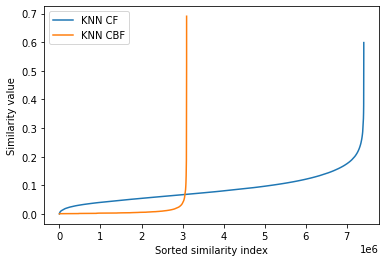

In [9]:
import numpy as np
import matplotlib.pyplot as pyplot


pyplot.plot(W_sparse_CF_sorted, label = 'KNN CF')
pyplot.plot(W_sparse_CBF_sorted, label = 'KNN CBF')
pyplot.ylabel('Similarity value')
pyplot.xlabel('Sorted similarity index')
pyplot.legend()
pyplot.show()

## Let's now plot the delta for the common values

In [10]:
# Get common structure
W_sparse_CF_structure = W_sparse_CF.copy()
W_sparse_CF_structure.data = np.ones_like(W_sparse_CF_structure.data)

W_sparse_CBF_structure = W_sparse_CBF.copy()
W_sparse_CBF_structure.data = np.ones_like(W_sparse_CBF_structure.data)

W_sparse_common = W_sparse_CF_structure.multiply(W_sparse_CBF_structure)

# Get values of both in common structure of CF
W_sparse_delta = W_sparse_CBF.copy().multiply(W_sparse_common)
W_sparse_delta -= W_sparse_CF.copy().multiply(W_sparse_common)

In [11]:
W_sparse_delta_sorted = np.sort(W_sparse_delta.data.copy())

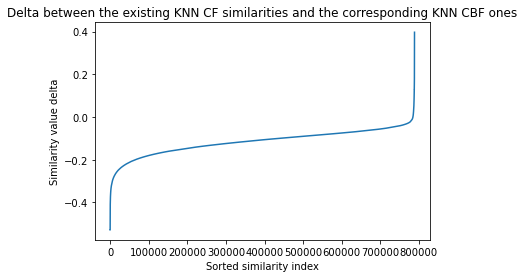

In [12]:
pyplot.plot(W_sparse_delta_sorted)
pyplot.ylabel('Similarity value delta')
pyplot.xlabel('Sorted similarity index')
pyplot.title("Delta between the existing KNN CF similarities and the corresponding KNN CBF ones")
pyplot.show()

In [13]:
# How many values we have in common?

print("W_sparse_CF has {:.2E} values and {:.2f} % in common with CBF".format(W_sparse_CF.nnz, W_sparse_common.nnz/W_sparse_CF.nnz*100))
print("W_sparse_CBF has {:.2E} values and {:.2f} % in common with CF".format(W_sparse_CBF.nnz, W_sparse_common.nnz/W_sparse_CBF.nnz*100))

print("W_sparse_delta has {:.2E} values".format(W_sparse_delta.nnz))


W_sparse_CF has 7.42E+06 values and 10.63 % in common with CBF
W_sparse_CBF has 3.10E+06 values and 25.45 % in common with CF
W_sparse_delta has 7.88E+05 values


## What do we see?
## The great majority of similarities are not common... the KNNs are modeling two very different phenomena

# Idea: 

what if we were to weight features in such a way to approximate as well as possible the collaborative similarity?

Basic model:  $S_{CBF} = ICM \cdot diag(feature\_weights) \cdot ICM^{T}$ 


We want  $S_{CBF} = S_{CF}$

Hence we wish to find the weights such that  $S_{CF} = ICM \cdot diag(feature\_weights) \cdot ICM^{T}$ 

Now, we can rearrange the equations considering that we need only weights for features the two items have in common... this becomes a regression problem in form Ax = b. In our case A are the common features, x the weights and b the collaborative similarity


### Since it is a regression problem, we can use an already available solver like linalg in scipy.sparse

### It takes as imput two data structures, one is sparse and the other is the target value

In [14]:
W_sparse_delta = W_sparse_delta.tocoo()


item_index_1 = W_sparse_delta.row[666]
item_index_2 = W_sparse_delta.col[666]

In [15]:
print("Item indices are {} and {}".format(item_index_1, item_index_2))

Item indices are 7 and 42


In [16]:
print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))

Collaborative similarity value is 0.18686850368976593
Content-based similarity value is 0.021173948422074318


### Compute the common features

In [17]:
common_features = ICM_tags[item_index_1,:].multiply(ICM_tags[item_index_2,:])
common_features

<1x10106 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [18]:
common_features.indices

array([  25,   33,   94,  145,  511,  550, 2538, 5518, 5728, 6107],
      dtype=int32)

## These items have just two common features, that is a common scenario

### Let's look for items having  a few features in common, say 5

In [19]:
import scipy.sparse as sps

min_common_features = 5
common_features = sps.csr_matrix((1,1))
inner_index = 0

while (common_features.nnz < min_common_features and inner_index<len(W_sparse_delta.row)):

    item_index_1 = W_sparse_delta.row[inner_index]
    item_index_2 = W_sparse_delta.col[inner_index]
    inner_index += 1
    
    common_features = ICM_tags[item_index_1,:].multiply(ICM_tags[item_index_2,:])      
        

print("Item indices are {} and {}".format(item_index_1, item_index_2))

print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))
    
common_features.indices

Item indices are 1 and 11
Collaborative similarity value is 0.3871592581272125
Content-based similarity value is 0.10350184142589569


array([   8,  489,  671,  672, 2593], dtype=int32)

In [20]:
from scipy.sparse import linalg

loss_tolerance = 1e-6
iteration_limit = 50000
damp_coeff=0.0

W_sparse_CF_value = W_sparse_CF[item_index_1, item_index_2]

In [21]:
linalg_result = linalg.lsqr(common_features, W_sparse_CF_value, show = False,
                            atol=loss_tolerance, btol=loss_tolerance,
                            iter_lim = iteration_limit, damp=damp_coeff)

In [22]:
feature_weights = linalg_result[0].copy()
feature_weights

array([0., 0., 0., ..., 0., 0., 0.])

In [23]:
feature_weights[common_features.indices]

array([3.38891435e-04, 4.84130622e-05, 3.05002292e-03, 3.05002292e-03,
       1.45239186e-04])

### Note that all weights will be zeros except for the features those items have in common, nothing can be learned if a feature is not common

### If a dataset has a very sparse ICM, this FW method will struggle

In [24]:
new_CBF_value = common_features.dot(feature_weights)
new_CBF_value

array([0.38715926])

In [25]:
print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))

print("Weighted Content-based similarity value is {}".format(new_CBF_value[0]))

Collaborative similarity value is 0.3871592581272125
Content-based similarity value is 0.10350184142589569
Weighted Content-based similarity value is 0.38715925812721236


### Note that we learned the CF similarity amost exactly...

### Warning: 5 common features and 1 similarity value, more parameters than data points, overfitting!

### if we want to apply this method to the whole dataset we have to compute the common features of all items having a common similarity value. Whe already know who they are, thanks to W_sparse_delta

In [26]:
from Recommenders.FeatureWeighting.CFW_D_Similarity_Linalg import CFW_D_Similarity_Linalg

In [27]:
CFW_weithing = CFW_D_Similarity_Linalg(URM_train, ICM_tags, W_sparse_CF)
CFW_weithing.fit()

CFW_D_Similarity_Linalg: URM Detected 46 ( 0.4%) items with no interactions.
CFW_D_Similarity_Linalg: ICM Detected 3087 (28.9%) items with no features.
CFW_D_Similarity_Linalg: Generating train data
Similarity column 10681 (100.0%), 14068.36 column/sec. Elapsed time 0.76 sec
CFW_D_Similarity_Linalg: Collaborative S density: 6.50E-02, nonzero cells 7415187
CFW_D_Similarity_Linalg: Content S density: 1.73E-02, nonzero cells 1975457
CFW_D_Similarity_Linalg: Content S structure has 567640 out of 1975457 (28.7%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 7.51E+04, average is: 1.32E-01, average over all collaborative data is 8.64E-02
Similarity column 10681 (100.0%), 13885.38 column/sec. Elapsed time 0.77 sec


In [28]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[5, 10, 20])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[5, 10, 20])

EvaluatorHoldout: Ignoring 67415 ( 3.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 69805 ( 0.1%) Users that have less than 1 test interactions


In [29]:
results_df, _ = evaluator_test.evaluateRecommender(itemKNNCF)
results_df

EvaluatorHoldout: Processed 69805 (100.0%) in 2.89 min. Users per second: 402


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.311568,0.31824,0.103998,0.230186,0.234289,0.515758,0.241143,0.155944,0.724332,0.773383,...,0.075836,0.998955,0.723575,0.009682,6.970848,0.986868,0.04974,0.615551,1.9305,0.039192
10,0.26773,0.306406,0.169867,0.171386,0.191499,0.528319,0.251792,0.207856,0.81679,0.919716,...,0.101582,0.998955,0.815936,0.012401,7.379472,0.990963,0.063708,0.651634,1.829649,0.07913
20,0.218631,0.333019,0.258057,0.121338,0.172511,0.532908,0.27555,0.236714,0.881427,1.03504,...,0.133789,0.998955,0.880506,0.016322,7.807952,0.993838,0.083852,0.689471,1.706362,0.160229


In [30]:
results_df, _ = evaluator_test.evaluateRecommender(itemKNNCBF)
results_df

EvaluatorHoldout: Processed 69805 (100.0%) in 2.24 min. Users per second: 520


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.132996,0.134467,0.032536,0.089544,0.090417,0.282975,0.111531,0.052282,0.432362,0.354832,...,0.019567,0.998955,0.43191,0.002467,4.889391,0.943808,0.012672,0.431751,1.900615,0.039605
10,0.107369,0.115891,0.05029,0.058554,0.062473,0.297552,0.107655,0.068498,0.540362,0.408644,...,0.024623,0.998955,0.539798,0.003516,5.476874,0.963596,0.01806,0.483628,1.689557,0.081138
20,0.077085,0.102555,0.069606,0.035134,0.0447,0.302905,0.105773,0.073155,0.616045,0.440872,...,0.033705,0.998955,0.615401,0.005227,6.132445,0.979353,0.026854,0.541517,1.35263,0.170255


In [31]:
results_df, _ = evaluator_test.evaluateRecommender(CFW_weithing)
results_df

EvaluatorHoldout: Processed 69805 (100.0%) in 1.91 min. Users per second: 610


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.128581,0.129655,0.028334,0.083702,0.08426,0.251594,0.105564,0.046435,0.40722,0.323352,...,0.020316,0.998955,0.406795,0.002513,4.922491,0.946743,0.01291,0.434674,1.729163,0.040789
10,0.114579,0.122349,0.050053,0.059636,0.062446,0.268868,0.107934,0.06967,0.537025,0.388664,...,0.027057,0.998955,0.536464,0.00368,5.547019,0.966322,0.018904,0.489822,1.648456,0.082043
20,0.10095,0.13071,0.08555,0.04246,0.050417,0.277722,0.118983,0.092614,0.663505,0.447737,...,0.038667,0.998955,0.662812,0.005806,6.297284,0.981422,0.029827,0.556073,1.548863,0.165274


### This algorithm has hyperparameters too:
* topK, the usual number of neighbors
* add_zeros_quota, the percentage of zero collaborative similarities to add to the train set, this helps the regressor in finding non-relevant features
* normalize_similarity, apply or not the usual cosine denominator

In [32]:
from HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from skopt.space import Real, Integer, Categorical
from HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs


def hyperparameter_optimization_CFW_D(URM_train, ICM_train, W_sparse_CF):

    recommender_class = CFW_D_Similarity_Linalg

    parameterSearch = SearchBayesianSkopt(recommender_class,
                                     evaluator_validation=evaluator_validation,
                                     evaluator_test=evaluator_test)


    hyperparameters_range_dictionary = {}
    hyperparameters_range_dictionary["topK"] = Integer(5, 1000)
    hyperparameters_range_dictionary["add_zeros_quota"] = Real(low = 0, high = 1, prior = 'uniform')
    hyperparameters_range_dictionary["normalize_similarity"] = Categorical([True, False])


    recommender_input_args = SearchInputRecommenderArgs(
        CONSTRUCTOR_POSITIONAL_ARGS = [URM_train, ICM_train, W_sparse_CF],
        CONSTRUCTOR_KEYWORD_ARGS = {},
        FIT_POSITIONAL_ARGS = [],
        FIT_KEYWORD_ARGS = {}
    )


    output_folder_path = "result_experiments/"

    import os

    # If directory does not exist, create
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    n_cases = 10
    metric_to_optimize = "MAP"
    cutoff_to_optimize = 10


    # Clone data structure to perform the fitting with the best hyperparameters on train + validation data
    recommender_input_args_last_test = recommender_input_args.copy()
    recommender_input_args_last_test.CONSTRUCTOR_POSITIONAL_ARGS[0] = URM_train + URM_validation


    parameterSearch.search(recommender_input_args,
                           recommender_input_args_last_test = recommender_input_args_last_test,
                           hyperparameter_search_space = hyperparameters_range_dictionary,
                           n_cases = n_cases,
                           n_random_starts = int(n_cases/3),
                           save_model = "no",
                           evaluate_on_test = "last",
                           output_folder_path = output_folder_path,
                           output_file_name_root = recommender_class.RECOMMENDER_NAME,
                           metric_to_optimize = metric_to_optimize,
                           cutoff_to_optimize = cutoff_to_optimize
                          )


In [33]:
hyperparameter_optimization_CFW_D(URM_train, ICM_tags, W_sparse_CF)

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 561, 'add_zeros_quota': 0.890362988450008, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: URM Detected 46 ( 0.4%) items with no interactions.
CFW_D_Similarity_Linalg: ICM Detected 3087 (28.9%) items with no features.
CFW_D_Similarity_Linalg: Generating train data
Similarity column 10681 (100.0%), 13831.74 column/sec. Elapsed time 0.77 sec
CFW_D_Similarity_Linalg: Collaborative S density: 6.50E-02, nonzero cells 7415187
CFW_D_Similarity_Linalg: Content S density: 3.00E-02, nonzero cells 3420680
CFW_D_Similarity_Linalg: Content S structure has 876028 out of 3420680 (25.6%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.14E+05, average is: 1.30E-01, average over all collaborative data is 8.64E-02
Similarity column 10681 (100.0%), 11892.97 column/sec. Elapsed time 0.90 sec
EvaluatorHoldout: Processed 67415 (100.0%) in 2.41 min. User

Similarity column 10681 (100.0%), 12065.84 column/sec. Elapsed time 0.89 sec
CFW_D_Similarity_Linalg: Collaborative S density: 6.50E-02, nonzero cells 7415187
CFW_D_Similarity_Linalg: Content S density: 4.73E-02, nonzero cells 5391649
CFW_D_Similarity_Linalg: Generating train data. Sample 671315 (12.7%) 
CFW_D_Similarity_Linalg: Generating train data. Sample 1286544 (24.3%) 
CFW_D_Similarity_Linalg: Content S structure has 1216982 out of 5391649 (22.6%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.56E+05, average is: 1.29E-01, average over all collaborative data is 8.64E-02
Similarity column 10681 (100.0%), 11487.17 column/sec. Elapsed time 0.93 sec
EvaluatorHoldout: Processed 67415 (100.0%) in 2.90 min. Users per second: 388
SearchBayesianSkopt: Config 4 is suboptimal. Config: {'topK': 1000, 'add_zeros_quota': 0.017288268337664617, 'normalize_similarity': False} - results: PRECISION: 0.0389424, PRECISION_RECALL_MIN_DEN: 0.0554399, RECALL: 0

CFW_D_Similarity_Linalg: URM Detected 46 ( 0.4%) items with no interactions.
CFW_D_Similarity_Linalg: ICM Detected 3087 (28.9%) items with no features.
CFW_D_Similarity_Linalg: Generating train data
Similarity column 10681 (100.0%), 12027.20 column/sec. Elapsed time 0.89 sec
CFW_D_Similarity_Linalg: Collaborative S density: 6.50E-02, nonzero cells 7415187
CFW_D_Similarity_Linalg: Content S density: 3.59E-02, nonzero cells 4096717
CFW_D_Similarity_Linalg: Generating train data. Sample 2719494 (132.8%) 
CFW_D_Similarity_Linalg: Content S structure has 1001348 out of 4096717 (24.4%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.30E+05, average is: 1.29E-01, average over all collaborative data is 8.64E-02
Similarity column 10681 (100.0%), 12991.43 column/sec. Elapsed time 0.82 sec
EvaluatorHoldout: Processed 67415 (100.0%) in 2.28 min. Users per second: 494
SearchBayesianSkopt: Config 8 is suboptimal. Config: {'topK': 700, 'add_zeros_quota': 1.0,

### The best solution has a MAP of 0.099, better than the pure CBF

### Let's try another ICM, the genres of the movie

In [34]:
CFW_weithing_genre = CFW_D_Similarity_Linalg(URM_train, ICM_genres, W_sparse_CF)
CFW_weithing_genre.fit()

results_df, _ = evaluator_test.evaluateRecommender(CFW_weithing_genre)
results_df

CFW_D_Similarity_Linalg: URM Detected 46 ( 0.4%) items with no interactions.
CFW_D_Similarity_Linalg: Generating train data
Similarity column 10681 (100.0%), 9218.28 column/sec. Elapsed time 1.16 sec
CFW_D_Similarity_Linalg: Collaborative S density: 6.50E-02, nonzero cells 7415187
CFW_D_Similarity_Linalg: Content S density: 2.80E-02, nonzero cells 3199455
CFW_D_Similarity_Linalg: Content S structure has 411533 out of 3199455 (12.9%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 3.95E+04, average is: 9.59E-02, average over all collaborative data is 8.64E-02
Similarity column 10681 (100.0%), 8849.61 column/sec. Elapsed time 1.21 sec
EvaluatorHoldout: Processed 69805 (100.0%) in 1.95 min. Users per second: 596


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.014363,0.014445,0.002632,0.006524,0.00656,0.028173,0.006822,0.004449,0.063892,0.030264,...,0.03979,0.998955,0.063826,0.027973,8.161773,0.991093,0.143706,0.720714,0.22539,0.06021
10,0.017841,0.018687,0.006383,0.005187,0.005406,0.037751,0.009484,0.009403,0.137913,0.043869,...,0.055613,0.998955,0.137769,0.035421,8.591438,0.994325,0.181967,0.758655,0.265454,0.118283
20,0.01916,0.0236,0.01393,0.003854,0.004545,0.045298,0.013035,0.016131,0.247776,0.057714,...,0.079955,0.998955,0.247517,0.044169,8.857605,0.995197,0.226904,0.782159,0.293409,0.233044


In [35]:
hyperparameter_optimization_CFW_D(URM_train, ICM_genres, W_sparse_CF)

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 169, 'add_zeros_quota': 0.8254251929198315, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: URM Detected 46 ( 0.4%) items with no interactions.
CFW_D_Similarity_Linalg: Generating train data
Similarity column 10681 (100.0%), 8737.98 column/sec. Elapsed time 1.22 sec
CFW_D_Similarity_Linalg: Collaborative S density: 6.50E-02, nonzero cells 7415187
CFW_D_Similarity_Linalg: Content S density: 1.58E-02, nonzero cells 1804515
CFW_D_Similarity_Linalg: Content S structure has 246314 out of 1804515 (13.6%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 2.39E+04, average is: 9.72E-02, average over all collaborative data is 8.64E-02
Similarity column 10681 (100.0%), 9176.54 column/sec. Elapsed time 1.16 sec
EvaluatorHoldout: Processed 67415 (100.0%) in 1.95 min. Users per second: 576
SearchBayesianSkopt: New best config found. Config 0: {'to

CFW_D_Similarity_Linalg: Content S structure has 618403 out of 5284995 (11.7%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 5.86E+04, average is: 9.48E-02, average over all collaborative data is 8.64E-02
Similarity column 10681 (100.0%), 8352.41 column/sec. Elapsed time 1.28 sec
EvaluatorHoldout: Processed 67415 (100.0%) in 1.89 min. Users per second: 593
SearchBayesianSkopt: Config 4 is suboptimal. Config: {'topK': 498, 'add_zeros_quota': 0.24899523372624272, 'normalize_similarity': False} - results: PRECISION: 0.0047215, PRECISION_RECALL_MIN_DEN: 0.0066265, RECALL: 0.0045562, MAP: 0.0012892, MAP_MIN_DEN: 0.0017591, MRR: 0.0116782, NDCG: 0.0036046, F1: 0.0046374, HIT_RATE: 0.0433286, ARHR_ALL_HITS: 0.0122695, NOVELTY: 0.0131355, AVERAGE_POPULARITY: 0.0587949, DIVERSITY_MEAN_INTER_LIST: 0.8996842, DIVERSITY_HERFINDAHL: 0.9899671, COVERAGE_ITEM: 0.2857410, COVERAGE_ITEM_CORRECT: 0.0311769, COVERAGE_USER: 0.9647529, COVERAGE_USER_CORRECT: 0.0418

SearchBayesianSkopt: Config 8 is suboptimal. Config: {'topK': 601, 'add_zeros_quota': 1.0, 'normalize_similarity': False} - results: PRECISION: 0.0047037, PRECISION_RECALL_MIN_DEN: 0.0066686, RECALL: 0.0046086, MAP: 0.0013318, MAP_MIN_DEN: 0.0018123, MRR: 0.0122015, NDCG: 0.0036554, F1: 0.0046556, HIT_RATE: 0.0435808, ARHR_ALL_HITS: 0.0127332, NOVELTY: 0.0130938, AVERAGE_POPULARITY: 0.0590907, DIVERSITY_MEAN_INTER_LIST: 0.8894659, DIVERSITY_HERFINDAHL: 0.9889453, COVERAGE_ITEM: 0.2525981, COVERAGE_ITEM_CORRECT: 0.0280873, COVERAGE_USER: 0.9647529, COVERAGE_USER_CORRECT: 0.0420447, DIVERSITY_GINI: 0.0192704, SHANNON_ENTROPY: 7.6984532, RATIO_DIVERSITY_HERFINDAHL: 0.9896917, RATIO_DIVERSITY_GINI: 0.0989964, RATIO_SHANNON_ENTROPY: 0.6798016, RATIO_AVERAGE_POPULARITY: 0.2051292, RATIO_NOVELTY: 0.1198570, 

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 211.6807
Function value obtained: -0.0013
Current minimum: -0.0024
Iteration No: 10 started. Searching for 

### Here the best solution has a MAP of 0.006... not great

Since we are weighting features, and weights can be applied only to common features, we may expect a sparse ICM to have limited quality gains because the items will tend to have few features in common and so only few parameters that can be learned. A more dense ICM may exhibit much higher improvements due to more common features and model parameters, however, very different items may have the same features in common, choking the model.

### Improvements of CF+CBF greatly depend on the ICM structure and collaborative data distribution...

## Tip:
If your ICM is very sparse and you get poor results, you may try to aggregate features (e.g., put them in OR, add them...) to reduce their number and get a new denser ICM on which to try feature weighting

## How about using these feature weights to perform feature selection?
## Let's try to select the x% features with highest value

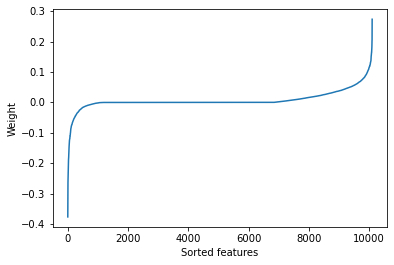

In [36]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(np.sort(CFW_weithing.D_best))
pyplot.ylabel('Weight')
pyplot.xlabel('Sorted features')
pyplot.show()

### Something to think about... do we select features with the 'highest' weight, hence excluding the negative ones, or do we select those that have the 'highest absolute' value, accounting also for the strong negative ones?

In [41]:
argsort_features = np.argsort(-CFW_weithing.D_best)

map_list = []
selection_quota_list = [0.3, 0.5, 0.7, 0.9]

for selection_quota in selection_quota_list:
    
    n_to_select = int(selection_quota*len(argsort_features))
    selected_features = argsort_features[:n_to_select]
    
    ICM_selected = ICM_tags[:,selected_features]
    
    print("Selected {}/{} features, weights: {:.2E} to {:.2E}".format(n_to_select, len(argsort_features),
                                                                min(CFW_weithing.D_best[selected_features]),
                                                                max(CFW_weithing.D_best[selected_features])))
    
    itemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM_selected)
    itemKNNCBF.fit(**best_hyperparams_ItemKNNCBF)
    
    results_df, _ = evaluator_test.evaluateRecommender(itemKNNCBF)
    map_list.append(results_df.loc[10]["MAP"])
    
    

Selected 3031/10106 features, weights: 3.26E-03 to 2.73E-01
ItemKNNCBFRecommender: URM Detected 46 ( 0.4%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3298 (30.9%) items with no features.
Similarity column 10681 (100.0%), 8924.71 column/sec. Elapsed time 1.20 sec
EvaluatorHoldout: Processed 69805 (100.0%) in 2.34 min. Users per second: 497
Selected 5053/10106 features, weights: 0.00E+00 to 2.73E-01
ItemKNNCBFRecommender: URM Detected 46 ( 0.4%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3140 (29.4%) items with no features.
Similarity column 10681 (100.0%), 8929.66 column/sec. Elapsed time 1.20 sec
EvaluatorHoldout: Processed 69805 (100.0%) in 2.14 min. Users per second: 545
Selected 7074/10106 features, weights: 0.00E+00 to 2.73E-01
ItemKNNCBFRecommender: URM Detected 46 ( 0.4%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3130 (29.3%) items with no features.
Similarity column 10681 (100.0%), 9009.28 column/sec. Elapsed time 1

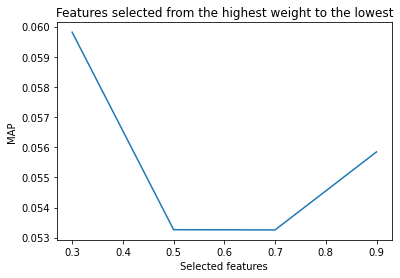

In [42]:
pyplot.plot(selection_quota_list, map_list)
pyplot.ylabel('MAP')
pyplot.xlabel('Selected features')
pyplot.title("Features selected from the highest weight to the lowest")
pyplot.show()

In [43]:
argsort_features = np.argsort(np.abs(CFW_weithing.D_best))

map_list = []
selection_quota_list = [0.3, 0.5, 0.7, 0.9]

for selection_quota in selection_quota_list:
    
    n_to_select = int(selection_quota*len(argsort_features))
    selected_features = argsort_features[:n_to_select]
    
    ICM_selected = ICM_tags[:,selected_features]
    
    print("Selected {}/{} features, weights: {:.2E} to {:.2E}".format(n_to_select, len(argsort_features),
                                                                min(CFW_weithing.D_best[selected_features]),
                                                                max(CFW_weithing.D_best[selected_features])))
    
    itemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM_selected)
    itemKNNCBF.fit(**best_hyperparams_ItemKNNCBF)
    
    results_df, _ = evaluator_test.evaluateRecommender(itemKNNCBF)
    map_list.append(results_df.loc[10]["MAP"])
    
    

Selected 3031/10106 features, weights: 0.00E+00 to 0.00E+00
ItemKNNCBFRecommender: URM Detected 46 ( 0.4%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 8696 (81.4%) items with no features.
Similarity column 10681 (100.0%), 15491.99 column/sec. Elapsed time 0.69 sec
EvaluatorHoldout: Processed 69805 (100.0%) in 1.60 min. Users per second: 726
Selected 5053/10106 features, weights: 0.00E+00 to 0.00E+00
ItemKNNCBFRecommender: URM Detected 46 ( 0.4%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 7993 (74.8%) items with no features.
Similarity column 10681 (100.0%), 15773.41 column/sec. Elapsed time 0.68 sec
EvaluatorHoldout: Processed 69805 (100.0%) in 1.61 min. Users per second: 722
Selected 7074/10106 features, weights: -1.11E-02 to 1.11E-02
ItemKNNCBFRecommender: URM Detected 46 ( 0.4%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 4005 (37.5%) items with no features.
Similarity column 10681 (100.0%), 9578.82 column/sec. Elapsed tim

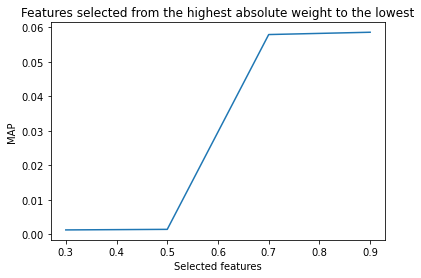

In [44]:
pyplot.plot(selection_quota_list, map_list)
pyplot.ylabel('MAP')
pyplot.xlabel('Selected features')
pyplot.title("Features selected from the highest absolute weight to the lowest")
pyplot.show()